<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание Ultra pro**

Возьмите собственную базу изображений и их сегментированных изображений. И обучите модель сегментировать изображение на заданные классы.

In [ ]:
# загрузка библиотек
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, BatchNormalization, Activation, Input, concatenate, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
#распаковываем архив на google диске на локальный диск google colaboratory
!unzip -q '/content/drive/My Drive/data/archive.zip'

In [ ]:
# загрузка данных
# создадим переменные, куда будем сохранять данные
images = []
masks = []
for image in sorted(os.listdir('/content/underwater/images/')):
    # проходим по каждому файлу, получив список файлов в папке
    img = load_img('/content/underwater/images/'+image, target_size=(176, 240))
    #загружаем файл, устанавливаем нужный размер и сохраняем
    images.append(np.array(img))

for image in sorted(os.listdir('/content/underwater/masks/')):
    img = load_img('/content/underwater/masks/'+image, target_size=(176, 240))
    masks.append(np.array(img))

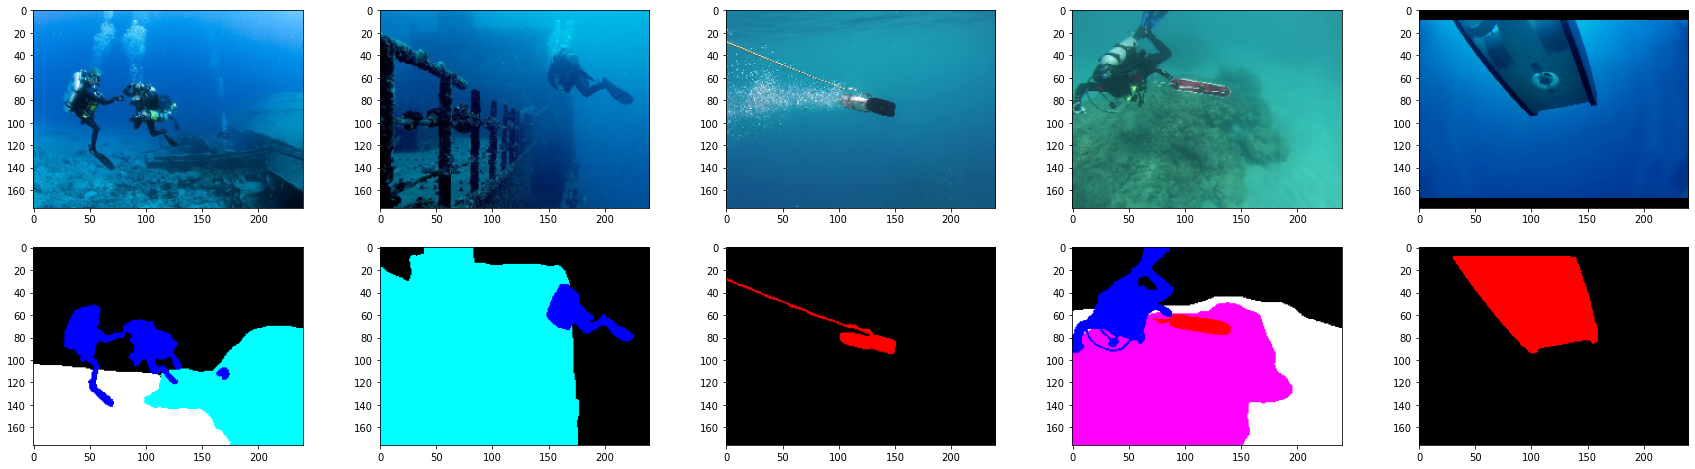

In [ ]:
# проверим синхронизированность данных
plt.figure(figsize=(30, 8))
for i in range(5):
    # Показываем картинки из набора lips
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    
    # Показываем картинки из набора masks
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(masks[i])
plt.show()

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс
def color2index(color):
    index=-1
    if (49>=color[0]>0)and(49>=color[1]>=0)and(49>=color[2]>=0):
        index=0 # вода
    elif (49>=color[0]>=0)and(49>=color[1]>=0)and(255>=color[2]>=230):
        index=1 # люди
    elif (49>=color[0]>=0)and(255>=color[1]>=230)and(49>=color[2]>=0):
        index=2 # водоросли
    elif (49>=color[0]>=0)and(255>=color[1]>=230)and(255>=color[2]>=230):
        index=3 # обломки и руины
    elif (255>=color[0]>=230)and(49>=color[1]>=0)and(49>=color[2]>=0):
        index=4 # подводные аппараты
    elif (255>=color[0]>=230)and(49>=color[1]>=0)and(255>=color[2]>=230):
        index=5 # рифы и ракушки
    elif (255>=color[0]>=230)and(255>=color[1]>=230)and(49>=color[2]>=0):
        index=6 # рыбы
    elif (255>=color[0]>=230)and(255>=color[1]>=230)and(255>=color[2]>=230):
        index=7 # морское дно и скалы
    else:
        index = 8
    return index


# Функция преобразования индекса в цвет пикселя
def index2color(index2):
    # Получаем индекс максимального элемента
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # вода
    elif index == 1:
        color = [0, 0, 255]  # люди
    elif index == 2:
        color = [0, 255, 0]  # водоросли
    elif index == 3:
        color = [0, 255, 255]  # обломки и руины
    elif index == 4:
        color = [255, 0, 0]  # подводные аппараты
    elif index == 5:
        color = [255, 0, 255]  # рифы и ракушки
    elif index == 6:
        color = [255, 255, 0]  # рыбы
    elif index == 7:
        color = [255, 255, 255]  # морское дно и скалы
    elif index == 8:
        color = [100, 100, 100]  # остальное
    # Возвращаем цвет пикселя
    return color


# Функция перевода индекса пикселя в to_categorical
def rgbToohe(y, num_classes):
    # Создаем копию входного массива
    y2 = y.copy()
    # Решейпим в двумерный массив
    y = y.reshape(y.shape[0] * y.shape[1], 3)
    # Создаем пустой лист
    yt = []
    # Проходим по всем трем каналам изображения
    for i in range(len(y)):
        # Переводим пиксели в индексы и преобразуем в OneHotEncoding
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes))
    # Преобразуем в numpy массив
    yt = np.array(yt)
    # Решейпим к исходному размеру
    yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes)
    # Возвращаем сформированный массив
    return yt


# Функция формирования yTrain
def yt_prep(data, num_classes):
    # Создаем пустой список под карты сегментации
    yTrain = []
    # Пробегаем по всем файлам набора с сегментированными изображениями
    for seg in data:
        # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = img_to_array(seg)
        # Получаем категорийное представление сформированного массива
        y = rgbToohe(y, num_classes)
        # Добавляем очередной элемент в yTrain
        yTrain.append(y)
        # Каждые 100 шагов
        if len(yTrain) % 100 == 0:
            # Выводим количество обработанных изображений
            print(len(yTrain))
    
    # Возвращаем сформированный yTrain
    return np.array(yTrain)

In [ ]:
# Создаем пустой список под обучающую выборку
xTrain = []
# пройдемся по каждому изображению
for img in images:
    # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    x = img_to_array(img)
    # Добавляем очередной элемент в xTrain
    xTrain.append(x)
# Переводим в numpy
xTrain = np.array(xTrain)
# Выводим размерность обучающей выборки
print(xTrain.shape)

(1525, 176, 240, 3)


In [ ]:
# Сформируем yTrain
yTrain = yt_prep(masks, 9)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [ ]:
# Сформируем обучающие и проверочные выборки
x_train, x_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size = 0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1220, 176, 240, 3)
(1220, 176, 240, 9)
(305, 176, 240, 3)
(305, 176, 240, 9)


In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    # Возвращаем площадь пересечения деленную на площадь объединения двух областей
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
# Создаем модель
img_input = Input(shape=(176, 240, 3))

# первая U-Net
x = Conv2D(64, (3, 3), padding='same')(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
block_1 = Activation('relu')(x)

x = MaxPool2D(2)(block_1)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
block_2 = Activation('relu')(x)

x = MaxPool2D(2)(block_2)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
block_3 = Activation('relu')(x)

x = MaxPool2D(2)(block_3)

x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_3])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_2])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_1])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# вторая U-Net
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPool2D(2)(block_1)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPool2D(2)(block_2)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPool2D(2)(block_3)

x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_3])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_2])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_1])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# PSPNet
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

pool_2 = MaxPool2D(2)(x)
pool_2 = Conv2D(128, (3, 3), padding='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)
pool_2 = Activation('relu')(pool_2)
pool_2 = Conv2D(128, (3, 3), padding='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)
pool_2 = Activation('relu')(pool_2)
pool_2 = Conv2D(128, (3, 3), padding='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)
pool_2 = Activation('relu')(pool_2)

pool_4 = MaxPool2D(4)(x)
pool_4 = Conv2D(256, (3, 3), padding='same')(pool_4)
pool_4 = BatchNormalization()(pool_4)
pool_4 = Activation('relu')(pool_4)
pool_4 = Conv2D(256, (3, 3), padding='same')(pool_4)
pool_4 = BatchNormalization()(pool_4)
pool_4 = Activation('relu')(pool_4)
pool_4 = Conv2D(256, (3, 3), padding='same')(pool_4)
pool_4 = BatchNormalization()(pool_4)
pool_4 = Activation('relu')(pool_4)

pool_8 = MaxPool2D(8)(x)
pool_8 = Conv2D(512, (3, 3), padding='same')(pool_8)
pool_8 = BatchNormalization()(pool_8)
pool_8 = Activation('relu')(pool_8)
pool_8 = Conv2D(512, (3, 3), padding='same')(pool_8)
pool_8 = BatchNormalization()(pool_8)
pool_8 = Activation('relu')(pool_8)
pool_8 = Conv2D(512, (3, 3), padding='same')(pool_8)
pool_8 = BatchNormalization()(pool_8)
pool_8 = Activation('relu')(pool_8)

pool_16 = MaxPool2D(16)(x)
pool_16 = Conv2D(1024, (3, 3), padding='same')(pool_16)
pool_16 = BatchNormalization()(pool_16)
pool_16 = Activation('relu')(pool_16)
pool_16 = Conv2D(1024, (3, 3), padding='same')(pool_16)
pool_16 = BatchNormalization()(pool_16)
pool_16 = Activation('relu')(pool_16)
pool_16 = Conv2D(1024, (3, 3), padding='same')(pool_16)
pool_16 = BatchNormalization()(pool_16)
pool_16 = Activation('relu')(pool_16)

up_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(pool_2)
up_2 = BatchNormalization()(up_2)
up_2 = Activation('relu')(up_2)
up_2 = Conv2D(64, (3, 3), padding='same')(up_2)
up_2 = BatchNormalization()(up_2)
up_2 = Activation('relu')(up_2)
up_2 = Conv2D(64, (3, 3), padding='same')(up_2)
up_2 = BatchNormalization()(up_2)
up_2 = Activation('relu')(up_2)

up_4 = Conv2DTranspose(64, (3, 3), strides=(4, 4), padding='same')(pool_4)
up_4 = BatchNormalization()(up_4)
up_4 = Activation('relu')(up_4)
up_4 = Conv2D(64, (3, 3), padding='same')(up_4)
up_4 = BatchNormalization()(up_4)
up_4 = Activation('relu')(up_4)
up_4 = Conv2D(64, (3, 3), padding='same')(up_4)
up_4 = BatchNormalization()(up_4)
up_4 = Activation('relu')(up_4)

up_8 = Conv2DTranspose(64, (3, 3), strides=(8, 8), padding='same')(pool_8)
up_8 = BatchNormalization()(up_8)
up_8 = Activation('relu')(up_8)
up_8 = Conv2D(64, (3, 3), padding='same')(up_8)
up_8 = BatchNormalization()(up_8)
up_8 = Activation('relu')(up_8)
up_8 = Conv2D(64, (3, 3), padding='same')(up_8)
up_8 = BatchNormalization()(up_8)
up_8 = Activation('relu')(up_8)

up_16 = Conv2DTranspose(64, (3, 3), strides=(16, 16), padding='same')(pool_16)
up_16 = BatchNormalization()(up_16)
up_16 = Activation('relu')(up_16)
up_16 = Conv2D(64, (3, 3), padding='same')(up_16)
up_16 = BatchNormalization()(up_16)
up_16 = Activation('relu')(up_16)
up_16 = Conv2D(64, (3, 3), padding='same')(up_16)
up_16 = BatchNormalization()(up_16)
up_16 = Activation('relu')(up_16)

x = concatenate([x, up_2, up_4, up_8, up_16])
x= Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(9, (3, 3), activation = 'softmax', padding='same')(x)

model = Model(img_input, x)

# Компилируем модель
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=[dice_coef])

Epoch 1/150
153/153 [==============================] - 147s 919ms/step - loss: 1.9839 - dice_coef: 0.1923 - val_loss: 2.1444 - val_dice_coef: 0.1622
Epoch 2/150
153/153 [==============================] - 140s 914ms/step - loss: 1.4799 - dice_coef: 0.3373 - val_loss: 1.6634 - val_dice_coef: 0.2956
Epoch 3/150
153/153 [==============================] - 141s 921ms/step - loss: 1.3380 - dice_coef: 0.3932 - val_loss: 1.3112 - val_dice_coef: 0.4004
Epoch 4/150
153/153 [==============================] - 141s 921ms/step - loss: 1.2764 - dice_coef: 0.4201 - val_loss: 1.2273 - val_dice_coef: 0.4586
Epoch 5/150
153/153 [==============================] - 141s 920ms/step - loss: 1.2111 - dice_coef: 0.4458 - val_loss: 1.1978 - val_dice_coef: 0.4977
Epoch 6/150
153/153 [==============================] - 141s 920ms/step - loss: 1.1790 - dice_coef: 0.4584 - val_loss: 1.1451 - val_dice_coef: 0.4986
Epoch 7/150
153/153 [==============================] - 141s 921ms/step - loss: 1.1539 - dice_coef: 0.4678 

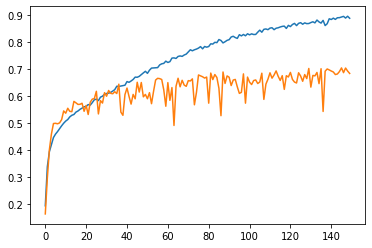

In [ ]:
history = model.fit(x_train, y_train, epochs=150, batch_size=8,
                    validation_data = (x_test, y_test))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

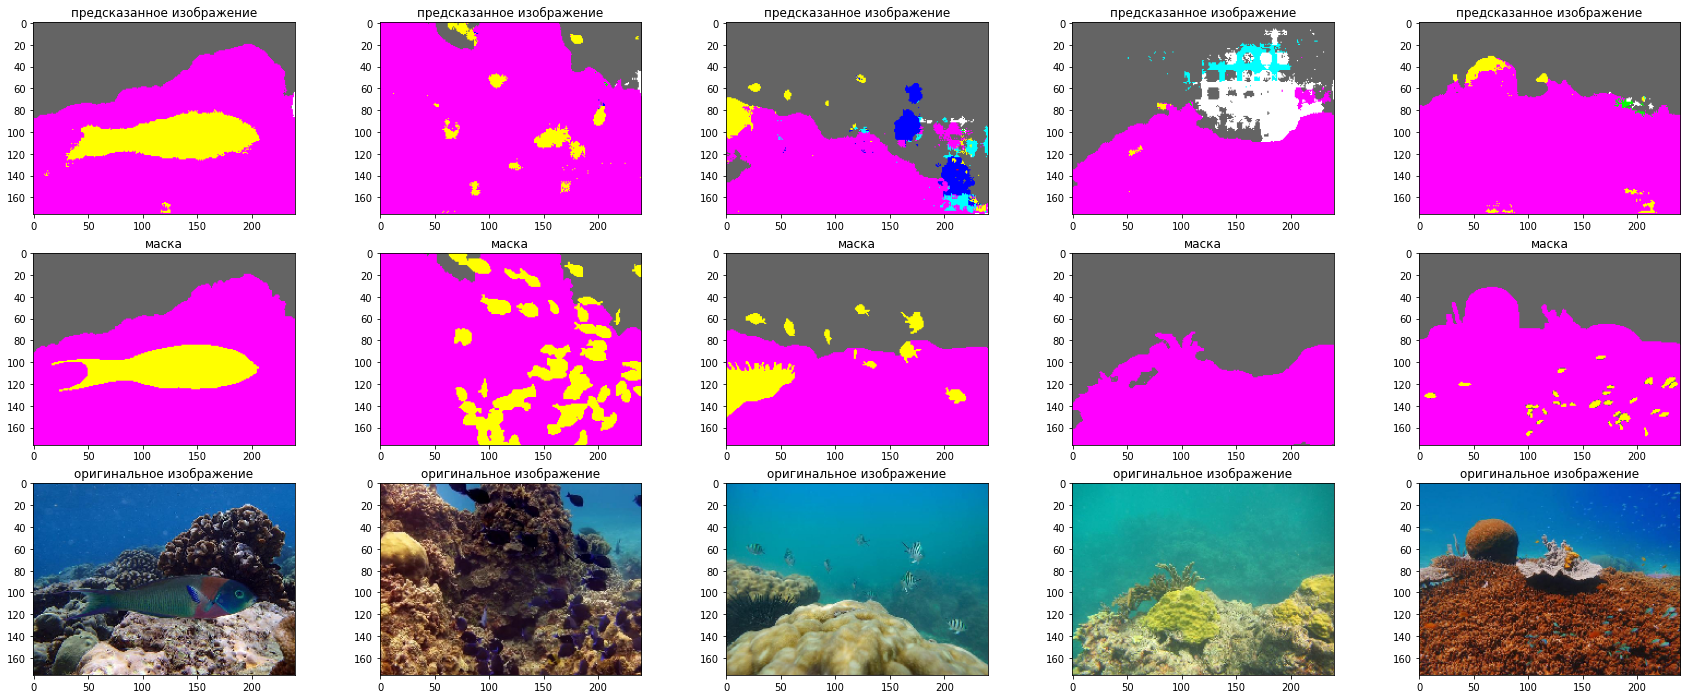

In [ ]:
# посмотрим результаты
# получим 5 случайных индексов
indexes = np.random.randint(0, len(x_test), 5)
fig, axs = plt.subplots(3, 5, figsize=(30, 12))
# проходим по всем индексам
for i,idx in enumerate(indexes):
    # предсказываем картинку
    predict = np.array(model.predict(x_test[idx].reshape(1, 176, 240, 3)))
    pr = predict[0]
    # пустой лист под сегментированную картинку из предсказаний
    pr1 = []
    # пустой лист под сегментированную картинку из проверочной выборки
    pr2 = []
    pr = pr.reshape(-1, 9)
    yr = y_test[idx].reshape(-1, 9)
    # проходим по всем уровням(количествам классов) и переводим индексы в пиксели
    for k in range(len(pr)):
        pr1.append(index2color(pr[k]))
        pr2.append(index2color(yr[k]))
    # преобразуем в массив numpy и решейпим к размеру изображения
    pr1 = np.array(pr1)
    pr1 = pr1.reshape(176, 240,3)
    pr2 = np.array(pr2)
    pr2 = pr2.reshape(176, 240,3)
    # получаем картинку
    img = Image.fromarray(pr1.astype('uint8'))
    axs[0,i].imshow(img.convert('RGBA'))
    axs[0,i].set_title('предсказанное изображение')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8')))
    axs[1,i].set_title('маска')
    axs[2,i].imshow(Image.fromarray(x_test[idx].astype('uint8')))
    axs[2,i].set_title('оригинальное изображение')
plt.show()

Epoch 1/50
153/153 [==============================] - 141s 924ms/step - loss: 0.1986 - dice_coef: 0.8959 - val_loss: 1.2149 - val_dice_coef: 0.7071
Epoch 2/50
153/153 [==============================] - 141s 919ms/step - loss: 0.2336 - dice_coef: 0.8820 - val_loss: 1.1024 - val_dice_coef: 0.6889
Epoch 3/50
153/153 [==============================] - 141s 922ms/step - loss: 0.2108 - dice_coef: 0.8902 - val_loss: 1.0244 - val_dice_coef: 0.6880
Epoch 4/50
153/153 [==============================] - 141s 920ms/step - loss: 0.2044 - dice_coef: 0.8948 - val_loss: 1.0618 - val_dice_coef: 0.6934
Epoch 5/50
153/153 [==============================] - 141s 919ms/step - loss: 0.2009 - dice_coef: 0.8953 - val_loss: 1.1972 - val_dice_coef: 0.6947
Epoch 6/50
153/153 [==============================] - 141s 921ms/step - loss: 0.1971 - dice_coef: 0.8973 - val_loss: 1.1304 - val_dice_coef: 0.6704
Epoch 7/50
153/153 [==============================] - 140s 919ms/step - loss: 0.2023 - dice_coef: 0.8957 - val_l

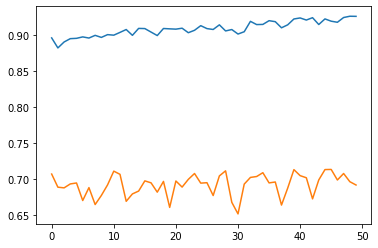

In [ ]:
# продолжим обучение еще на 50 эпохах
history = model.fit(x_train, y_train, epochs=50, batch_size=8,
                    validation_data = (x_test, y_test))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

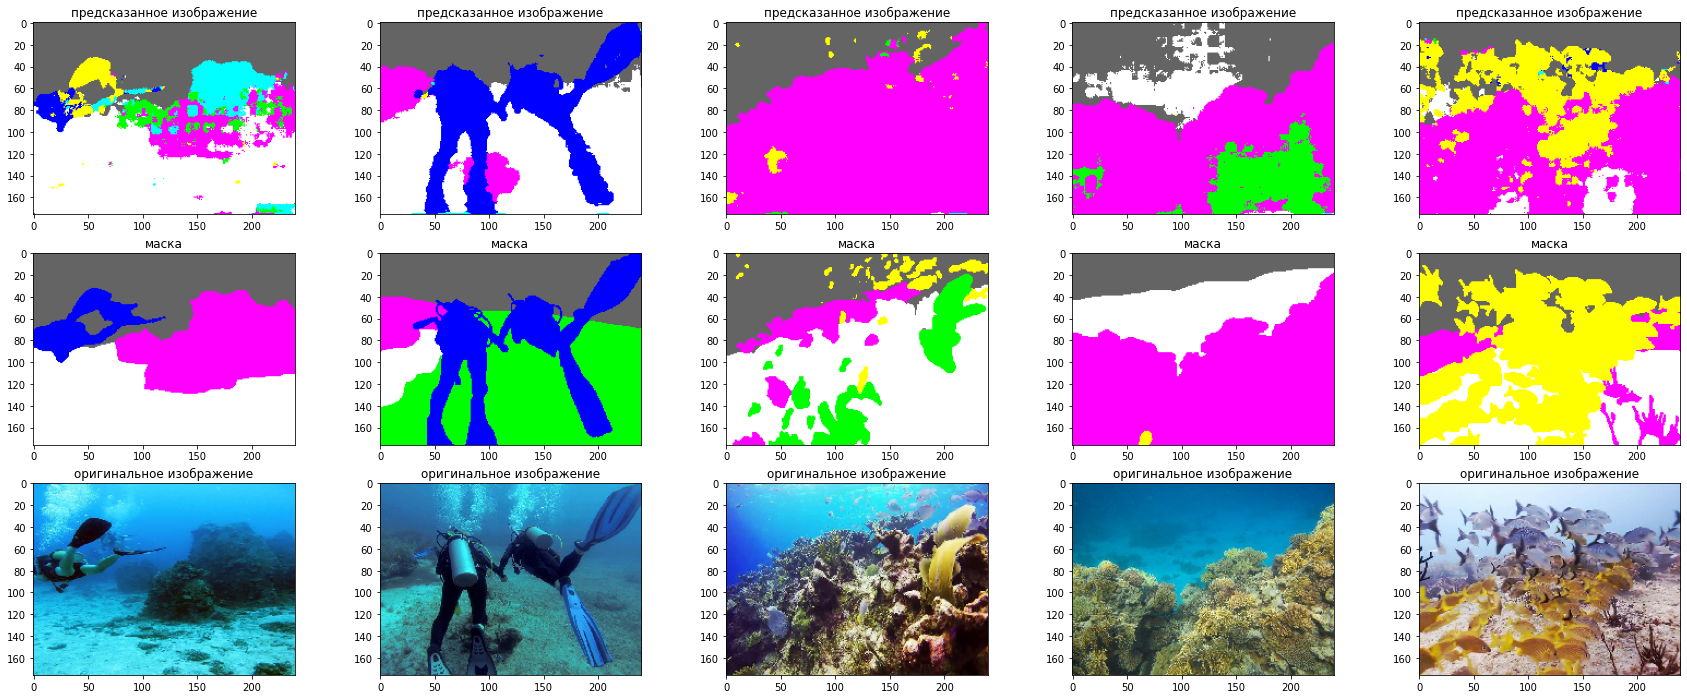

In [ ]:
# посмотрим результаты
# получим 5 случайных индексов
indexes = np.random.randint(0, len(x_test), 5)
fig, axs = plt.subplots(3, 5, figsize=(30, 12))
# проходим по всем индексам
for i,idx in enumerate(indexes):
    # предсказываем картинку
    predict = np.array(model.predict(x_test[idx].reshape(1, 176, 240, 3)))
    pr = predict[0]
    # пустой лист под сегментированную картинку из предсказаний
    pr1 = []
    # пустой лист под сегментированную картинку из проверочной выборки
    pr2 = []
    pr = pr.reshape(-1, 9)
    yr = y_test[idx].reshape(-1, 9)
    # проходим по всем уровням(количествам классов) и переводим индексы в пиксели
    for k in range(len(pr)):
        pr1.append(index2color(pr[k]))
        pr2.append(index2color(yr[k]))
    # преобразуем в массив numpy и решейпим к размеру изображения
    pr1 = np.array(pr1)
    pr1 = pr1.reshape(176, 240,3)
    pr2 = np.array(pr2)
    pr2 = pr2.reshape(176, 240,3)
    # получаем картинку
    img = Image.fromarray(pr1.astype('uint8'))
    axs[0,i].imshow(img.convert('RGBA'))
    axs[0,i].set_title('предсказанное изображение')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8')))
    axs[1,i].set_title('маска')
    axs[2,i].imshow(Image.fromarray(x_test[idx].astype('uint8')))
    axs[2,i].set_title('оригинальное изображение')
plt.show()